<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title data
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
batch_size = 4 # 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [3]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        # nn.Linear(num_ftrs, dim_embd, bias=None),
        # nn.Linear(512, dim_embd, bias=None),
        # nn.Softmax(dim=1),
        )
    return model
model = get_res(256).to(device)
print(model)
# input = torch.rand(16,3,64,64)
# input = torch.rand(16,1,256,256)
# out = model(input)
# print(out.shape)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [82]:
# @title autoencoder
import torch
import torch.nn as nn

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.encoder = torch.nn.Sequential(
        #     nn.Linear(28 * 28, 512), nn.ReLU(),
        #     nn.Linear(512, 128), nn.ReLU(),
        #     nn.Linear(128, 64), nn.ReLU(),
        #     nn.Linear(64, 32),  nn.ReLU(), # 32>10 to account for variation of members within the same class
        # )

        self.encoder = nn.Sequential( # 28 # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(1, 16, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 14
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 7
            nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 3
            nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 1
            # nn.Conv2d(32, 32, 3, stride=1, padding=1), # 1
            # nn.Conv2d(16, 8, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 3, stride=1, padding=0, output_padding=0), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0, output_padding=0), nn.ReLU(),
            # nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

        # self.decoder = nn.Sequential( # 'nearest', 'linear', 'bilinear', 'bicubic', 'trilinear'. # https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html
        #     nn.Upsample(scale_factor=2), nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(),
        #     nn.Upsample(2), nn.Conv2d(16, 1, 3, padding=1), nn.Sigmoid()
        # )

        # self.decoder = torch.nn.Sequential(
        #     nn.Linear(32, 64), nn.ReLU(),
        #     nn.Linear(64, 128), nn.ReLU(),
        #     nn.Linear(128, 512), nn.ReLU(),
        #     nn.Linear(512, 28 * 28),
        #     nn.ReLU(),
        # )


    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        x = self.encoder(x).squeeze()
        return x

    def decode(self, x):
        x = self.decoder(x.unsqueeze(-1).unsqueeze(-1))
        return x


device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder().to(device)
print(sum(p.numel() for p in model.encoder.parameters() if p.requires_grad))

# 477920

input = torch.rand((4,1,28,28), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



23296
torch.Size([4, 32])
torch.Size([4, 1, 28, 28])


In [ ]:
# @title train
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-8)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

epochs = 10
outputs = []
losses = []
model.train()
for epoch in range(epochs):
    for image, _ in train_loader:
        image = image.to(device)#.reshape(-1, 28*28)
        reconstructed = model(image)
        loss = loss_function(reconstructed, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu())
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    # print(lr)
    print("loss: ",sum(losses[-batch_size:]).item()/batch_size)
    outputs.append((epochs, image, reconstructed))


loss:  0.011691850610077381
loss:  0.012030640617012978
loss:  0.009366992861032486


In [79]:
# print(item[0].shape)
print(image.shape)


torch.Size([4, 1, 28, 28])


original:


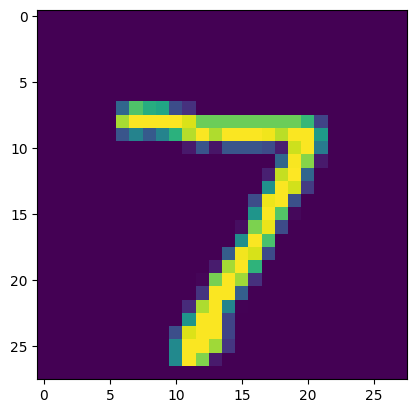

encoded:  tensor([[[2.7049, 2.7049, 2.7049, 2.7049, 2.7049, 2.7049, 2.7049],
         [2.1605, 3.5428, 4.1394, 3.3106, 2.9702, 3.0060, 2.1189],
         [2.3780, 1.6872, 0.0000, 1.4679, 1.6153, 3.2888, 2.3892],
         [2.1924, 2.2381, 2.2681, 3.1132, 3.2469, 2.6006, 2.2899],
         [2.1435, 2.1435, 2.3752, 3.2256, 1.2201, 2.6056, 2.1435],
         [2.1435, 2.1803, 3.1921, 1.7542, 2.4528, 2.3109, 2.1435],
         [2.2231, 2.3128, 2.8285, 1.1339, 2.8697, 2.2231, 2.2231]],

        [[1.8622, 1.8622, 1.8622, 1.8622, 1.8622, 1.8622, 1.8622],
         [1.9698, 2.6601, 5.5232, 4.1001, 3.3302, 3.3067, 1.8363],
         [2.1355, 1.8692, 6.6614, 7.0604, 7.0781, 7.4294, 2.1516],
         [1.8759, 1.8716, 1.9678, 2.9357, 6.4086, 7.2169, 1.8586],
         [1.8622, 1.8622, 2.3768, 3.2518, 7.1487, 3.2530, 1.8622],
         [1.8622, 1.8929, 2.9763, 7.7622, 6.7864, 1.8622, 1.8622],
         [1.8622, 1.9691, 2.4350, 7.8012, 2.9218, 1.8622, 1.8622]],

        [[2.3659, 2.3659, 2.3659, 2.3659, 2.3659

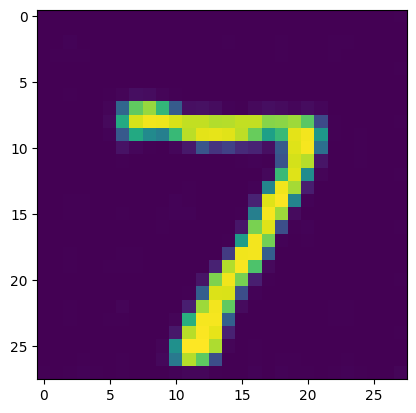

In [14]:
# @title evaluate

# dataiter = iter(test_loader)
dataiter = iter(test_data)
# item, labels = dataiter.next() # images, labels
item, labels = next(dataiter) # images, labels
# item = item.reshape(-1, 28, 28)
print("original:")
plt.imshow(item.cpu()[0])
plt.show()

model.eval()
# reconstructed = model(item[0].flatten().to(device))
# encoded = model.encode(item[0].flatten().to(device))
encoded = model.encode(item[0].unsqueeze(0).to(device))
print("encoded: ",encoded)
reconstructed = model.decode(encoded)

print("reconstructed:")
# reconstructed = reconstructed.reshape(-1, 28, 28)
# reconstructed = reconstructed.unsqueeze(0)
plt.imshow(reconstructed.detach().cpu()[0])
plt.show()
